<a href="https://colab.research.google.com/github/JD-man/DeepLearning_Study/blob/main/Chapter7/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 얼굴 검출과 얼굴 인식

# 안면 인식은 두 단계로 나눌 수 있다.
# 1. 얼굴 검출 : 이미지 내 얼굴을 탐지하고 분리한다. 얼굴이 여러 개 있다면 각각 따로 탐지해야한다. 원본에서 얼굴 부분만 잘라내야 한다.
# (face detection)
# 2. 얼굴 인식 : 이미지에서 검출한 얼굴을 신경망에 입력하고 대상이 누구인지 분류한다. 얼굴이 여러개 있다면 각 얼굴별로 작업을 반복한다.
# (face recognition)

# 사진 속 얼굴을 찾아내 확대한 다음 각 얼굴이 누구인지 인식한다.

In [3]:
# 얼굴 검출은 Haar Cascade, Eigenface, HOG(Histogram of Orented Gradients) 방식을 사용한다.
# 이 프로젝트에서는 Haar Cascade를 사용한다.

# 하르 특징
# 사람 얼굴을 정면에서 찍은 사진에는 눈, 코, 입술 등 얼굴 특징이 나타난다.
# 얼굴의 어두운 부분과 밝은 부분의 반복 패턴을 찾을 수 있다. 이 패턴을 하르 특징(Haar feature)라고 한다.

# 컨볼루션 레이어와의 차이
# 하르 특징은 컨볼루션 필터와 매우 비슷하다. 컨볼루션 레이어는 데이터셋을 사용해 학습시키는 반면에 하르 특징은 필터를 손수 제작한 것이다.

In [4]:
# Haar Cascade 방식은 다단계 분류 방식을 도입해 가장 단순한 하르 특징부터 영역에 대입한다.
# 영역과 하르 특징이 맞지 않는다면 다음 영역으로 넘어간다.
# 이러한 방식으로 계산량을 줄였다.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
cd /content/gdrive/MyDrive/Dataset/

/content/gdrive/MyDrive/Dataset


In [7]:
# 파이썬으로 얼굴 검출 구현. OpenCV를 이용한다.

import cv2

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [8]:
# 얼굴 검출 함수를 정의한다

def detect_faces(img, draw_box = True):
  grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(grayscale_img, scaleFactor = 1.1, minNeighbors=5, minSize=(30,30), flags=cv2.CASCADE_SCALE_IMAGE)
  face_box, face_coords = None, []

  for(x,y, width, height) in faces:
    if draw_box:
      cv2.rectangle(img, (x,y), (x+width, y+height), (0, 255, 0), 5)
      face_box = img[y:y+height, x:x+width]
      face_coords = [x,y,width,height]
  return img, face_box, face_coords

In [ ]:
# 견본 얼굴 파일에서 얼굴을 검출해본다.
import os
files = os.listdir('sample_faces')
images = [file for file in files if 'jpg' in file]
for image in images:
  img = cv2.imread('sample_faces/' + image)
  detected_faces, _, _ = detect_faces(img)
  cv2.imwrite('sample_faces/detected_faces/' + image, detected_faces)  

In [9]:
# 얼굴 인식

# 얼굴 인식 시스템의 독특한 요구 사항

# 1. 속도 : 안면 인식 시스템은 속도가 빨라야한다. 온보딩 과정을 보면 사용자는 여러 각도의 사진을 찍는다. 시스템은 몇 초내에 얼굴 이미지를 학습해야한다.
#           CNN의 경우 이 속도를 만족시키지 못한다. 온보딩 과정이 오래걸리므로 CNN은 요구 사항을 만족할 수 없다.

# 2. 확장성 : 이상적인 안면 인식 모델은 수백만 명의 얼굴을 인식하고 분간할 수 있어야한다. CNN은 이 요구사항도 만족할 수 없다.
#             CNN을 사용한다면 각 사용자별로 신경망을 따로 만들어야하며 이는 불가능에 가깝다. 메모리의 한계가 있으므로 CNN으로는 확장성을 갖춘 안면인식시스템을 못만든다.

# 3. 정확도 : 훈련데이터가 적어도 충분히 정확해야한다. 4장에서 CNN을 훈련시킬때는 고양이와 개 이미지 수천장을 사용했다.
#             안면 인식 모델에는 이렇게 풍족한 훈련데이터가 제공될 수 없다. CNN은 정확하지만 데이터셋이 상당히 많이 필요하다. CNN은 확장성에도 부적합하다.

In [10]:
# 사진 한장 만으로도 어떠한 얼굴도 인식하는 방법을 학습할 수 있는 신경망을 만들어야한다
# 이를 원샷 학습 (one-shot-learning)이라고 한다.

# 지금 Chapter 6까지와는 다르게 안면 인식 문제는 분류 문제가 아니라
# 입력 이미지 사이의 유사도를 추정하는 문제로 접근해야한다.

# 예시
# 1. A의 스마트폰을 누군가 사용하려고 한다. 온보딩 시 저장한 A의 얼굴 이미지를 로드한다.
# 2. 전면 카메라로 사용하려는 자의 얼굴 이미지를 찍는다. 이는 테스트 이미지가 된다.
# 3. 신경망은 정답 이미지와 테스트 이미지를 비교해 두 얼굴의 유사도를 출력한다.
# 4. 신경망이 출력한 유사도가 특정 임계치 이하라면 인증을 거부한다. 임계치 이상이면 인증을 수락한다.

In [11]:
# 벡터 간 유클리드 거리

# 정답 이미지와 테스트 이미지 사이의 차이를 단순하게 계산해 유사도를 도출할 수 있다.
# 컴퓨터 이미지는 3차원 벡터로 표현 할 수 있다. 그리고 두 벡터간 거리는 유클리드 거리로 계산할 수 있다.
# 두 이미지 사이의 유클리드 거리를 측정하면 두 이미지의 유사도를 판단할 수 있을 것이다.
# 하지만 이 방식은 안면 인식에 사용할 만큼 충분히 정확하지 않다.
# 실제 얼굴은 각도나 조도에 크게 영향을 받으며 대상의 모습도 안경이나 액세서리 등으로 다양할 수 있다.
# 유클리드 거리는 안면 인식 시스템을 구현하기에 적절하지 않다.

In [12]:
# 샴 신경망

# CNN과 유클리드 거리는 안면 인식 시스템이 사용할 수 없다.
# 하지만 각 방식은 유용하기 때문에 결합을 시도해본다.

# 사람이 얼굴을 인식하는 방식
# 사람은 얼굴의 주요 특징(눈 모양, 얼굴 형태 등)을 비교한다. 이러한 특징은 각도나 조도에 거의 영향을 받지 않는다.
# 신경망 또한 얼굴의 특징을 인식하고 유클리드 거리를 사용해 특징의 유사도를 측정할 수 있다.

# 원샷 학습 알고리즘
# 1. 컨볼루션 레이어를 사용해 얼굴의 특징을 인식하고 추출한다. 더 작은 차원의 특징벡터로 출력한다.
#    동일한 대상의 얼굴을 이 벡터 공간 내에 가까운 곳에 위치해야한다.
# 2. 컨볼루션 레이어가 출력한 원본벡터와 이미지벡터 사이의 유클리드 거리를 계산한다. 유클리드 거리는 유사도와 반비례한다. 유클리드 거리가 작을수록 유사도가 높음.

# 컨볼루션 레이어는 얼굴의 특징등을 각도나 조도에 관계없이 인식한다. 또한 이미지 화소 사이의 유클리드 거리를 계산하는 방식보다 낫다.
# 신경망에 두개의 이미지를 동시에 입력해야하며, 컨볼루션 레이어도 두개가 필요하다.
# 특징 공간 내에 매핑을 해야하므로 두 컨볼루션 레이어는 가중치를 공유해야한다.
# 두 컨볼루션 레이어가 마치 샴 쌍둥이같다고해서 샴 신경망이라고 부른다.

In [13]:
# 대조 손실

# 분류가 아닌 거리 비교를 하므로 손실 함수도 다른 종류가 필요하다.
# 분류 문제에는 categorical_crossentropy 등이 사용되지만 거리 비교에는 대조 손실 (contrastive loss)를 사용한다.

# 대조 손실 함수의 변수
# 1. Ytrue : 두 이미지가 동일한 대상이라면 1이고 다른 대상이면 0이다.
# 2. D : 신경망이 출력한 벡터의 거리

# Contrasive Loss = Ytrue * D^2 + (1 - Ytrue) * max(margin - D, 0)

# margin은 정규화효과를 주는 상수항이다.
# 비슷한 얼굴 사이의 거리가 크면 손실을 크게 계산하고 거리가 작으면 손실도 작게 계산한다.
# 비슷한 얼굴인데 예측거리가 크면 손실이 크므로 손실을 줄이기 위해 예측거리가 작아지도록 페널티를 부과한다. (p.324)

In [14]:
# 얼굴 데이터셋 다루기

# 얼굴 데이터셋 폴더
faces_dir = 'att_faces/'

In [16]:
# 이미지를 넘파이 배열로 로드하기

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# 40개중 35개를 훈련 데이터셋으로 사용하고, 나머지 다섯 명을 테스트 데이터셋에 할당한다.

X_train, y_train = [], []
X_test, y_test = [], []

# faces_dir 아래의 하위 디렉터리 목록을 가져온다
subfolders = sorted([f.path for f in os.scandir(faces_dir) if f.is_dir()])

# 하위 디렉터리 목록을 대상으로 반복문을 시작한다
# idx를 대상의 ID로 사용한다

for idx, folder in enumerate(subfolders):
  for file in sorted(os.listdir(folder)):
    img = load_img(folder + "/" + file, color_mode = 'grayscale')
    img = img_to_array(img).astype('float32')/255
    img = img.reshape(img.shape[0], img.shape[1], 1)
    if idx < 35:
      X_train.append(img)
      y_train.append(idx)
    else:
      X_test.append(img)
      y_test.append(idx - 35)

# 넘파이 배열로 변환한다

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

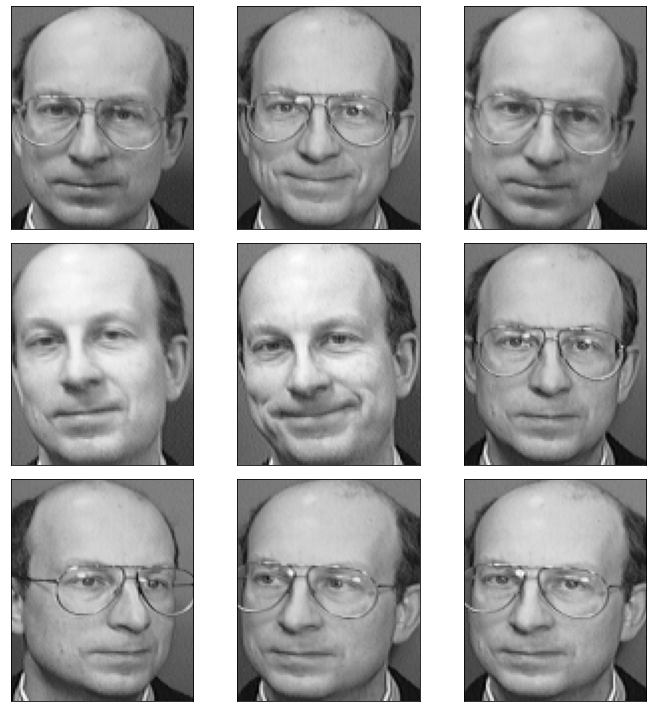

In [17]:
# 대상의 사진 9개를 가져오기
import matplotlib.pyplot as plt

subject_idx = 4
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (10,10))
subject_img_idx = np.where(y_train == subject_idx)[0].tolist()
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
  img = X_train[subject_img_idx[i]]
  img = np.squeeze(img)
  ax.imshow(img, cmap='gray')
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

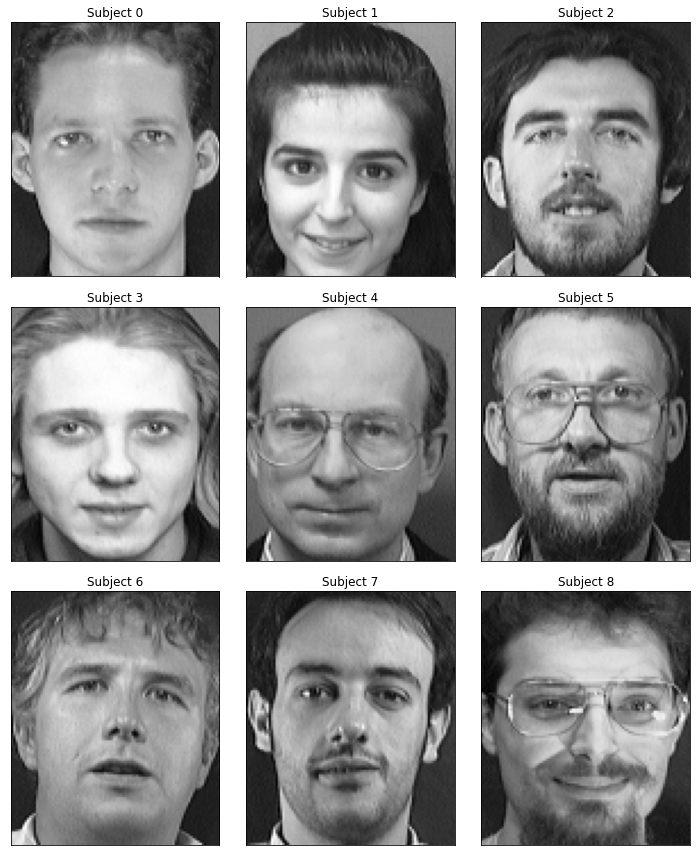

In [18]:
# 첫 아홉명의 사진을 그려보기

subjects = range(10)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (10,12))
subject_img_idx = [np.where(y_train == i)[0].tolist()[0] for i in subjects]

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
  img = X_train[subject_img_idx[i]]
  img = np.squeeze(img)
  ax.imshow(img, cmap='gray')
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title("Subject {}".format(i))

plt.tight_layout()
plt.show()

In [80]:
# 케라스 샴 신경망 아키텍쳐

from keras.models import Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_shared_network(input_shape):
  model = Sequential()
  model.add(Conv2D(filters = 64, kernel_size = (3,3), activation='relu', input_shape = input_shape))
  model.add(MaxPooling2D())
  model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(units=128, activation='sigmoid'))
  return model

In [81]:
# 컨볼루션 레이어를 복자하고 가중치를 공유하게하기.
# 신경망을 두개 만들필요는 없고, 케라스에 신경망 단일 객체만 선언하면 두개를 단번에 얻을 수 있다.

# 위에서 만든 create_shared_network 함수로 단일 객체를 생성한다.
input_shape = X_train.shape[1:]
shared_network = create_shared_network(input_shape)

# 케라스의 Input 클래스를 사용해 입력 레이어를 두개 만든다.
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)

# 케라스의 함수형 메서드를 사용해 오른쪽에 단일 객체로 만든 신경망을 이어 붙일 수 있다.
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)

In [83]:
# 유클리드 거리를 계산한다 각 출력은 (128, 1) 벡터이다.
# 케라스는 두 배열의 유클리드 거리를 계산하는 레이어를 제공하지 않는다.
# 케라스의 Lambda 레이어를 사용해 커스텀 레이어를 정의한다.

# 유클리드 거리 구하는 함수
from keras import backend as K
def euclidean_distance(vectors):
  vector1, vector2 = vectors
  sum_square = K.sum(K.square(vector1 - vector2), axis = 1, keepdims = True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

# 위의 함수를 Lambda 레이어로 래핑한다
from keras.layers import Lambda
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])

# 앞서 만든 Input과 결합해 모델을 완성한다.
from keras.models import Model
model3 = Model(inputs = [input_top, input_bottom], outputs = distance)

# 모델 확인

print(model3.summary())



Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 128)          18707264    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 1)            0           sequential_4[0][0]         

In [84]:
# 모델 훈련

# 샴 신경망은 CNN과 달리 이미지 배열의 쌍을 훈련 데이터셋으로 사용해야한다.
# 클래스 레이블도 이미지가 아닌 이미지 쌍 별로 필요하다.
# 동일인이면 1, 다른 사람이면 0이다.

# X_train, y_train 데이터로 새로운 이미지 배열 쌍을 생성하는 함수가 필요하다.
# 동일인의 이미지 쌍과 다른 인물의 이미지 쌍 개수가 동일해야한다.
# 동일인, 다른 인물의 이미지 쌍을 하나씩 번갈아 만들어야한다. 이러면 특정 이미지에 편향을 가지지 않고 고르게 학습할 수 있다.

import random

def create_pairs(X, y, num_classes):
  pairs, labels = [], []
  class_idx = [np.where(y==i)[0] for i in range(num_classes)]
  min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
  for c in range(num_classes):
    for n in range(min_images):
      img1 = X[class_idx[c][n]]
      img2 = X[class_idx[c][n+1]]
      pairs.append((img1, img2))
      labels.append(1)

      neg_list = list(range(num_classes))
      neg_list.remove(c)

      neg_c = random.sample(neg_list, 1)[0]
      img1 = X[class_idx[c][n]]
      img2 = X[class_idx[neg_c][n]]
      pairs.append((img1, img2))
      labels.append(0)
  return np.array(pairs), np.array(labels)

training_pairs, training_labels = create_pairs(X_train, y_train, len(np.unique(y_train)))

test_pairs, test_labels = create_pairs(X_test, y_test, len(np.unique(y_test)))

training_labels = training_labels.astype('float32')
test_labels = test_labels.astype('float32')

In [85]:
# 대조 손실 함수 만들기

# Y_true : 훈련데이터쌍의 레이블, D : 예측 거리

def contrastive_loss(Y_true, D):
  margin = 1
  return K.mean(Y_true * K.square(D) + (1 - Y_true) * K.maximum((margin - D), 0))

In [86]:
# 컴파일 하기

model3.compile(loss = contrastive_loss, optimizer='adam')

In [87]:
# 훈련하기

model3.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels, batch_size=128, epochs=10)

Epoch 1/10
5/5 [==============================] - 1s 108ms/step - loss: 0.3294
Epoch 2/10
5/5 [==============================] - 1s 103ms/step - loss: 0.1196
Epoch 3/10
5/5 [==============================] - 1s 105ms/step - loss: 0.0858
Epoch 4/10
5/5 [==============================] - 1s 102ms/step - loss: 0.0520
Epoch 5/10
5/5 [==============================] - 1s 104ms/step - loss: 0.0347
Epoch 6/10
5/5 [==============================] - 1s 105ms/step - loss: 0.0217
Epoch 7/10
5/5 [==============================] - 1s 103ms/step - loss: 0.0152
Epoch 8/10
5/5 [==============================] - 1s 103ms/step - loss: 0.0110
Epoch 9/10
5/5 [==============================] - 1s 104ms/step - loss: 0.0102
Epoch 10/10
5/5 [==============================] - 1s 102ms/step - loss: 0.0078


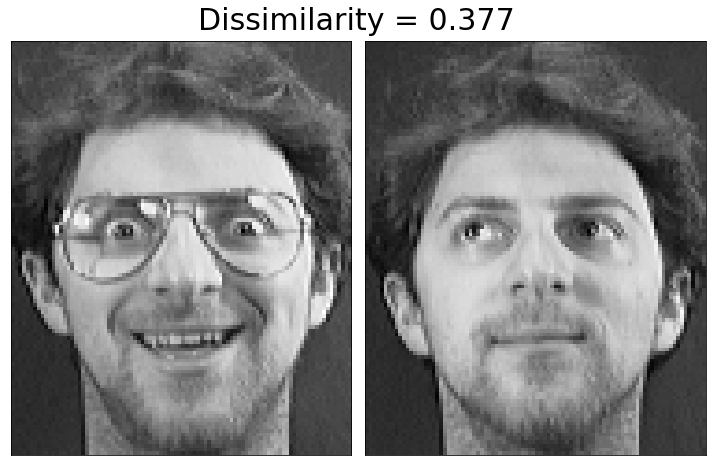

In [89]:
# 결과 확인

idx1, idx2 = 21, 29

img1 = np.expand_dims(X_test[idx1], axis=0)
img2 = np.expand_dims(X_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

dissimilarity = model3.predict([img1, img2])[0][0]
fig.suptitle("Dissimilarity = {:.3f}".format(dissimilarity), size = 30)
plt.tight_layout()
plt.show()

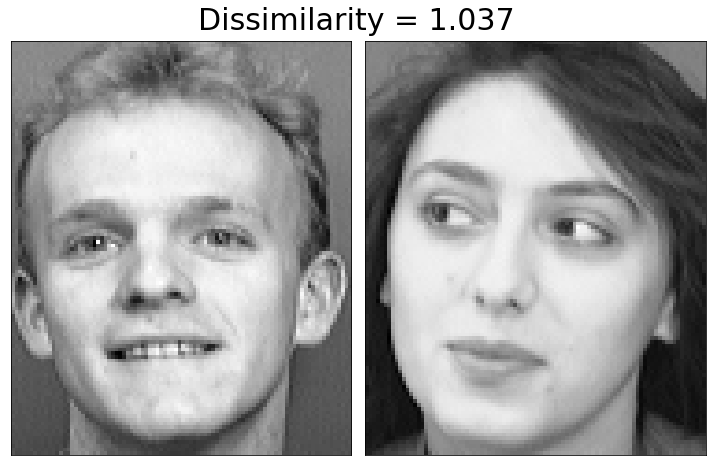

In [90]:
idx1, idx2 = 1, 39

img1 = np.expand_dims(X_test[idx1], axis=0)
img2 = np.expand_dims(X_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

dissimilarity = model3.predict([img1, img2])[0][0]
fig.suptitle("Dissimilarity = {:.3f}".format(dissimilarity), size = 30)
plt.tight_layout()
plt.show()

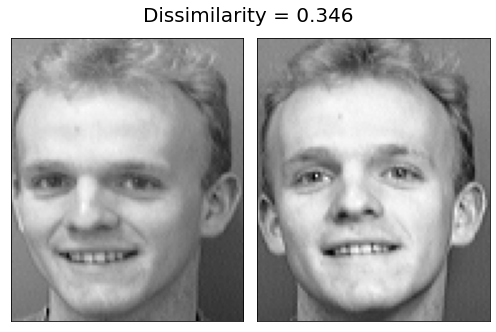

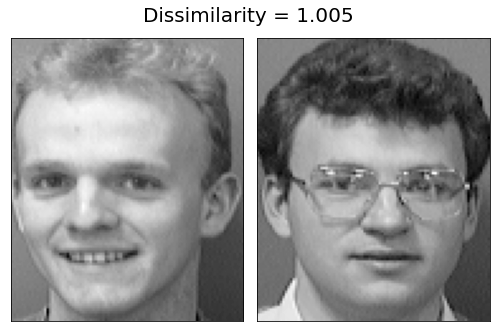

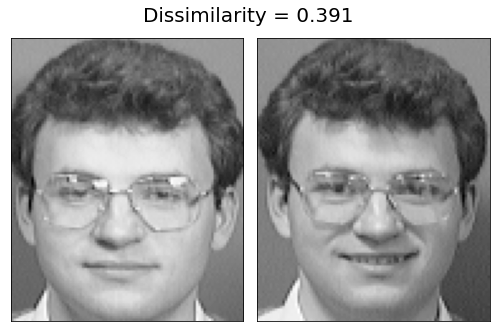

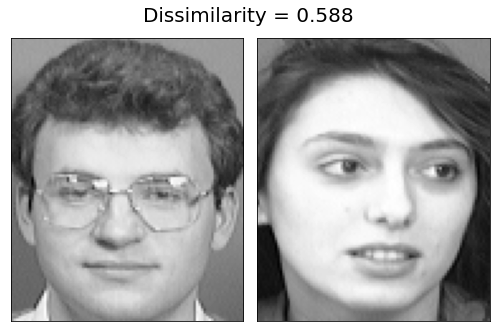

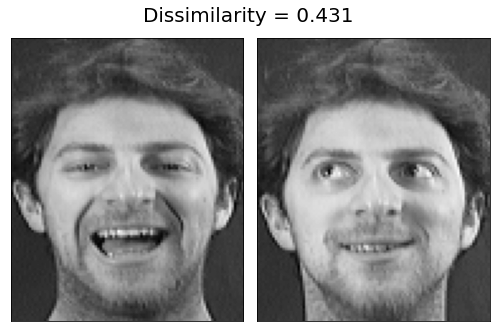

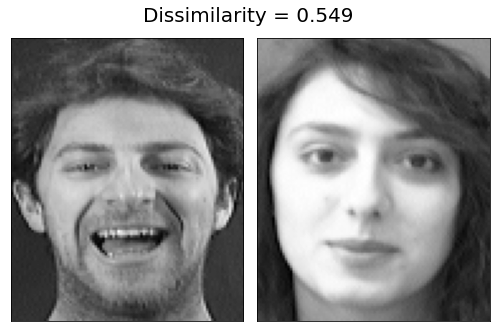

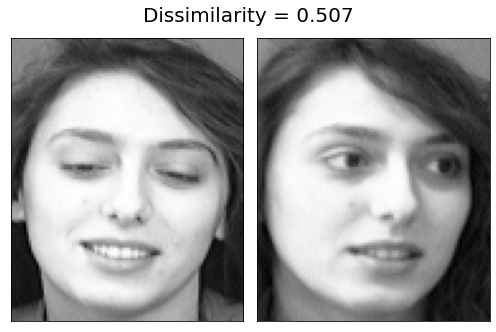

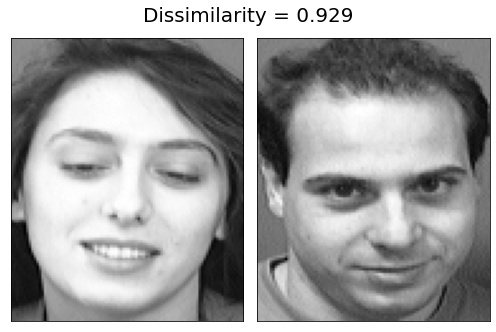

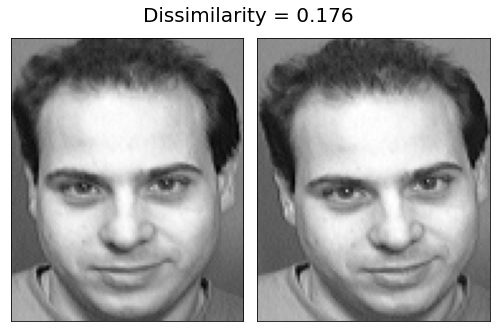

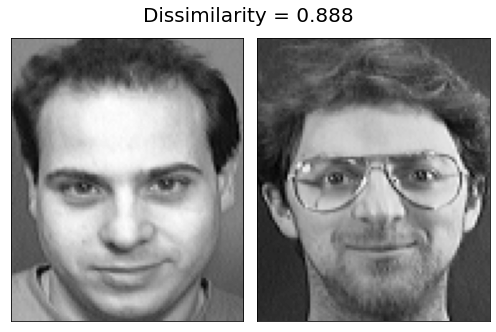

In [91]:
for i in range(5):
  for n in range(0, 2):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7,5))
    img1 = np.expand_dims(test_pairs[i*20+n , 0], axis = 0)
    img2 = np.expand_dims(test_pairs[i*20+n, 1], axis=0)
    dissimilarity= model3.predict([img1, img2])[0][0]
    img1, img2 = np.squeeze(img1), np.squeeze(img2)
    ax1.imshow(img1, cmap='gray')
    ax2.imshow(img2, cmap='gray')
    for ax in [ax1, ax2]:
      ax.grid(False)
      ax.set_xticks([])
      ax.set_yticks([])
    plt.tight_layout()
    fig.suptitle("Dissimilarity = {:.3f}".format(dissimilarity), size = 20)

plt.show()